## Prerequisites

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

In [3]:

dataset_meta = ['allen_'+x for x in ['B08','C01','F08','H12']]
cluster_names = ['Glutamatergic','GABAergic']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [4]:
dataset_names

['allen_B08_Glutamatergic',
 'allen_B08_GABAergic',
 'allen_C01_Glutamatergic',
 'allen_C01_GABAergic',
 'allen_F08_Glutamatergic',
 'allen_F08_GABAergic',
 'allen_H12_Glutamatergic',
 'allen_H12_GABAergic']

In [5]:
import loompy as lp
with lp.connect(loom_filepaths[0], mode="r") as ds:
    gene_names = ds.ra[gene_attr]


In [6]:
gene_names

array(['AC125149.3', 'AC125149.1', 'AC125149.4', ..., 'Gm37998',
       'Gm37263', 'Gm37286'], dtype=object)

In [7]:
markers = ['Slc17a7', 'Grina', 'Gria3', 'Grm1', 'Grm5', 'Slc17a6',
      'Gad1', 'Gad2', 'Gabra3', 'Slc32a1', 'Slc6a1', 'Slc6a5']


In [8]:
markers_sep = [['Slc17a7', 'Grina', 'Gria3', 'Grm1', 'Grm5', 'Slc17a6'],
      ['Gad1', 'Gad2', 'Gabra3', 'Slc32a1', 'Slc6a1', 'Slc6a5']]


In [9]:
all([x in gene_names for x in markers])

True

## Filtering

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [11]:
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta

In [12]:
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_v3 = get_allen_meta(meta_directory_v3)


Dataset B08. 
	10975 barcodes in loom, 9216 pass filter. 8424 in annotations; of these, 8424 in loom and 7808 in filtered loom.
	Glutamatergic: 5369 cells in annotations. 5369 in loom. 5355 pass filter.
	GABAergic: 855 cells in annotations. 855 in loom. 834 pass filter.
Dataset C01. 
	12363 barcodes in loom, 11116 pass filter. 10173 in annotations; of these, 10138 in loom and 9066 in filtered loom.
	Glutamatergic: 6702 cells in annotations. 6699 in loom. 6629 pass filter.
	GABAergic: 750 cells in annotations. 750 in loom. 728 pass filter.
Dataset F08. 
	28362 barcodes in loom, 10039 pass filter. 9112 in annotations; of these, 9112 in loom and 8510 in filtered loom.
	Glutamatergic: 5941 cells in annotations. 5941 in loom. 5929 pass filter.
	GABAergic: 739 cells in annotations. 739 in loom. 723 pass filter.
Dataset H12. 
	9637 barcodes in loom, 8168 pass filter. 6866 in annotations; of these, 6865 in loom and 6161 in filtered loom.
	Glutamatergic: 4530 cells in annotations. 4530 in loom.

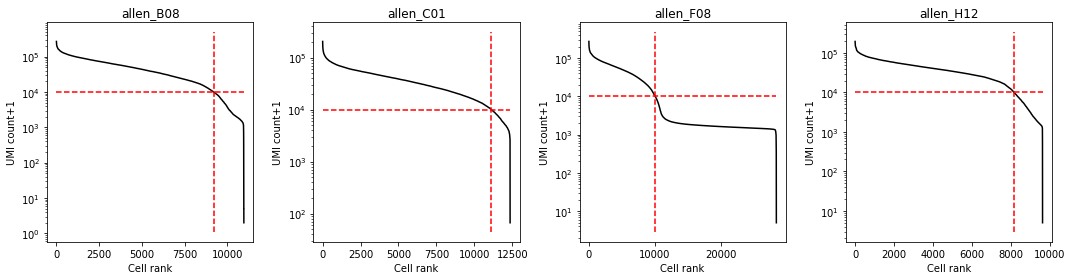

In [13]:
cf = []
thr_lb = [1e4]*4

fig1,ax1 = plt.subplots(1,4,figsize=(15,4))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = k
    filename = loom_filepaths[k*2]
    dataset_name = raw_data_locations[k*2][-3:]
    
    meta = meta_v3
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[axloc],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
        for cluster in cluster_names:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['class_label']==cluster)]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1[axloc].set_title(raw_data_locations[k*2])
fig1.tight_layout()

In [14]:
[x.sum() for x in cf]


[5355, 834, 6629, 728, 5929, 723, 4518, 669]

## Preprocessing

In [15]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1 already exists.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:5355 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:8156 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic already exists.
INFO:root:Dataset: allen_B08_GABAergic
INFO:root:834 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6325 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1/allen_B08_GABAergic already exists.
INFO:root:Dataset: allen_C01_Glutamatergic
INFO:root:6629 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7298 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221119_

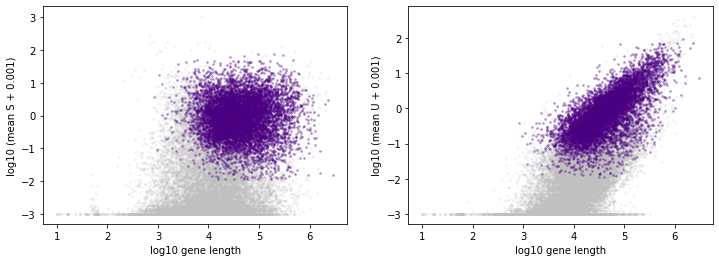

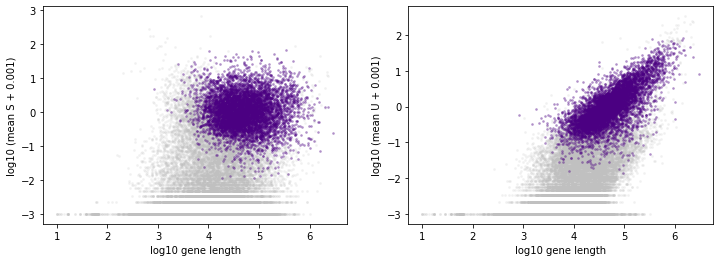

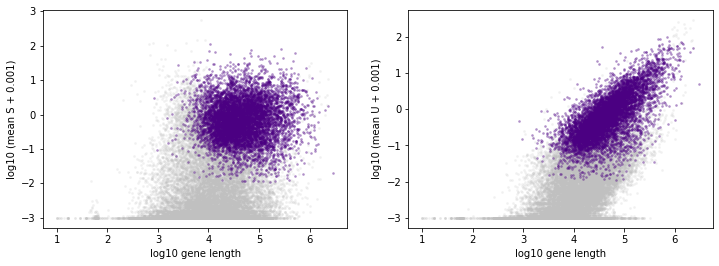

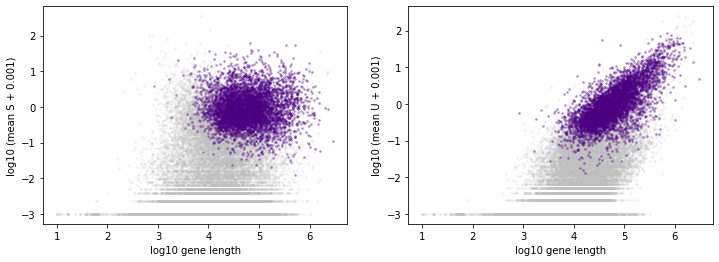

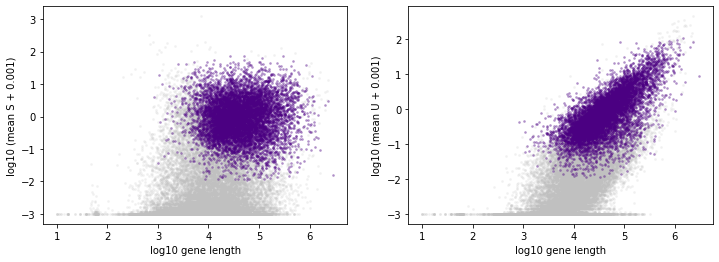

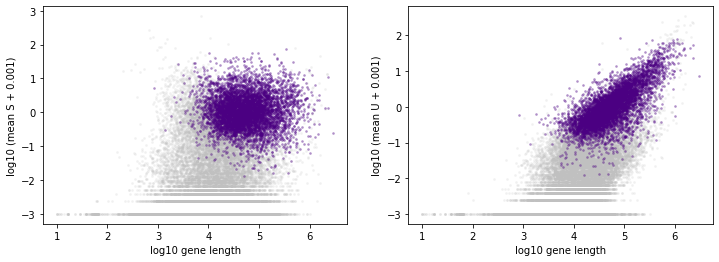

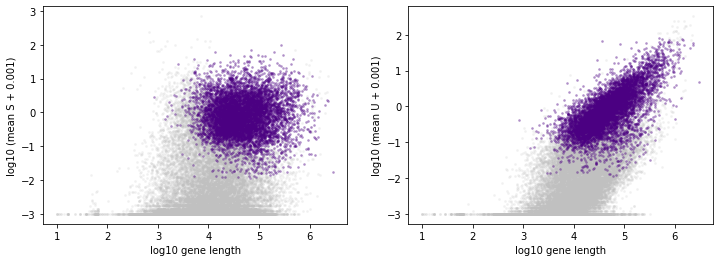

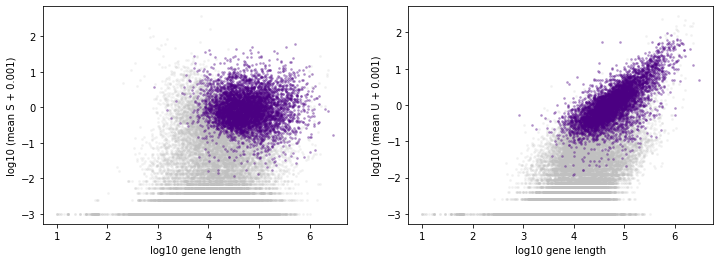

In [16]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_celltypes',batch_id=1,\
                                             n_genes=5000,exp_filter_threshold=None,cf=cf,
                                             genes_to_fit=markers)

## Inference

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


In [ ]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-6.10526316, -0.5625]
samp_ub = [-6.10526316, -0.5625]
gridsize = [1,1]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
    result_strings.append(full_result_string)


INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B08_Glutamatergic
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_221119_025_allen_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221119_025_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_1x1/analysis_figures created.
INFO:roo

## Post-processing

In [ ]:
dataset_names

In [ ]:
dir_string

In [ ]:
result_strings

In [ ]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    sr.find_sampling_optimum()

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [63]:
# dir_string = './fits/gg_221118_025_pbmc_celltypes_1'
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]